# Total Sales Prediction Using ARIMA

Author: Jaelani (Jay)

**Content:**
1.   Introduction
2.   Importing Libraries
3.   Dataset Overview
4.   Data Cleaning
5.   Model Machine Learning




# 1. Introduction

**Dataset Informastion**
*   Dataset ini terdiri dari 4 csv file yaitu customer, store, product dan transaction.
*   Merupakan dummy data untuk studi kasus FMCG dalam kurun waktu 1 tahun yang diambil melalui program membership.

**Attribute Information**
*   Customer
 - `CustomerID`: No Unik Customer
 - `Age`: Usia Customer
 - `Gender`: 0 Wanita, 1 Pria
 - `Marital Status`: Married, Single (Blm menikah/Pernah menikah)
 - `Income` : Pendapatan per bulan dalam jutaan rupiah

*   Store
 - `StoreID`: Kode Unik Store
 - `StoreName`: Nama Toko
 - `GroupStore`: Nama group
 - `Type`: Modern Trade, General Trade
 - `Latitude`: Kode Latitude
 - `Longitude`: Kode Longitude

*   Product
 - `ProductID`: Kode Unik Product
 - `Product Name`: Nama Product
 - `Price`: Harga dlm rupiah

*   Transaction
 - `TransactionID`: Kode Unik Transaksi
 - `Date`: Tanggal transaksi
 - `Qty`: Jumlah item yang dibeli
 - `Total Amount`: Price x Qty

**Company Goals**
*   Kamu adalah seorang Data Scientist di Kalbe Nutritionals dan sedang mendapatkan project baru dari tim inventory.
*   Dari tim inventory, kamu diminta untuk dapat membantu memprediksi jumlah penjualan (quantity) dari total keseluruhan product Kalbe

**Objectives**
*   Untuk mengetahui perkiraan quantity product yang terjual sehingga tim inventory dapat membuat stock persediaan harian yang cukup.
*   Prediksi yang dilakukan harus harian








# 2. Importing Libraries


In [1]:
# Installing Library ARIMA
! pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.4 MB/s eta 0:00:00


In [2]:
# Basic
import pandas as pd
import numpy as np

# Data Viz
import matplotlib.pyplot as plt
import seaborn as sns

# Melihat Pola Data (Trend, Seasonality, Residual)
from statsmodels.tsa.seasonal import seasonal_decompose

# Stationary Test
from statsmodels.tsa.stattools import adfuller

# Verifikasi using Autocorrelation Plot
from statsmodels.graphics.tsaplots import plot_acf
# Partial Autocorrelation Plot
from statsmodels.graphics.tsaplots import plot_pacf

# ARIMA Model
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from pandas.plotting import autocorrelation_plot

# Model Evaluasi
from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings('ignore')

# 3. Dataset Overview

## 3.1. Reading Dataset

In [3]:
customer = pd.read_csv('/content/drive/MyDrive/Datasets/Dataset Kalbe Nutritional - Data Scientist - PBI - Final Project/Case Study - Customer.csv', delimiter=';')
product = pd.read_csv('/content/drive/MyDrive/Datasets/Dataset Kalbe Nutritional - Data Scientist - PBI - Final Project/Case Study - Product.csv', delimiter=';')
store = pd.read_csv('/content/drive/MyDrive/Datasets/Dataset Kalbe Nutritional - Data Scientist - PBI - Final Project/Case Study - Store.csv', delimiter=';')
transaction = pd.read_csv('/content/drive/MyDrive/Datasets/Dataset Kalbe Nutritional - Data Scientist - PBI - Final Project/Case Study - Transaction.csv', delimiter=';')

In [4]:
customer.head()

,CustomerID,Age,Gender,Marital Status,Income
0,1,55,1,Married,"5,12"
1,2,60,1,Married,"6,23"
2,3,32,1,Married,"9,17"
3,4,31,1,Married,"4,87"
4,5,58,1,Married,"3,57"


In [5]:
product.head()

,ProductID,Product Name,Price
0,P1,Choco Bar,8800
1,P2,Ginger Candy,3200
2,P3,Crackers,7500
3,P4,Potato Chip,12000
4,P5,Thai Tea,4200


In [6]:
store.head()

,StoreID,StoreName,GroupStore,Type,Latitude,Longitude
0,1,Prima Tendean,Prima,Modern Trade,"-6,2","106,816666"
1,2,Prima Kelapa Dua,Prima,Modern Trade,"-6,914864","107,608238"
2,3,Prima Kota,Prima,Modern Trade,"-7,797068","110,370529"
3,4,Gita Ginara,Gita,General Trade,"-6,966667","110,416664"
4,5,Bonafid,Gita,General Trade,"-7,250445","112,768845"


In [7]:
transaction.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID
0,TR11369,328,01/01/2022,P3,7500,4,30000,12
1,TR16356,165,01/01/2022,P9,10000,7,70000,1
2,TR1984,183,01/01/2022,P1,8800,4,35200,4
3,TR35256,160,01/01/2022,P1,8800,7,61600,4
4,TR41231,386,01/01/2022,P9,10000,1,10000,4


## 3.2. Data Shape



In [8]:
customer.shape, product.shape, store.shape, transaction.shape

((447, 5), (10, 3), (14, 6), (5020, 8))

# 4. Data Cleaning

## 4.1. Data Merge

In [9]:
df = pd.merge(transaction,customer,on='CustomerID', how='inner')
df = pd.merge(df,product,on='ProductID',how='inner')
df = pd.merge(df,store,on='StoreID', how='inner')
df.head()

,TransactionID,CustomerID,Date,ProductID,Price_x,Qty,TotalAmount,StoreID,Age,Gender,Marital Status,Income,Product Name,Price_y,StoreName,GroupStore,Type,Latitude,Longitude
0,TR11369,328,01/01/2022,P3,7500,4,30000,12,36,0,Married,"10,53",Crackers,7500,Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554"
1,TR89318,183,17/07/2022,P3,7500,1,7500,12,27,1,Single,"0,18",Crackers,7500,Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554"
2,TR9106,123,26/09/2022,P3,7500,4,30000,12,34,0,Married,"4,36",Crackers,7500,Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554"
3,TR4331,335,08/01/2022,P3,7500,3,22500,12,29,1,Single,"4,74",Crackers,7500,Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554"
4,TR6445,181,10/01/2022,P3,7500,4,30000,12,33,1,Married,"9,94",Crackers,7500,Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554"


## 4.2. Data Shape

In [10]:
df.shape

(5020, 19)

## 4.3. Data Type Checking

In [11]:
df.dtypes

TransactionID     object
CustomerID         int64
Date              object
ProductID         object
Price_x            int64
Qty                int64
TotalAmount        int64
StoreID            int64
Age                int64
Gender             int64
Marital Status    object
Income            object
Product Name      object
Price_y            int64
StoreName         object
GroupStore        object
Type              object
Latitude          object
Longitude         object
dtype: object

### 4.3.1. Change Date Datatype

In [12]:
df['Date'] = pd.to_datetime(df['Date'])

In [13]:
df.dtypes

TransactionID             object
CustomerID                 int64
Date              datetime64[ns]
ProductID                 object
Price_x                    int64
Qty                        int64
TotalAmount                int64
StoreID                    int64
Age                        int64
Gender                     int64
Marital Status            object
Income                    object
Product Name              object
Price_y                    int64
StoreName                 object
GroupStore                object
Type                      object
Latitude                  object
Longitude                 object
dtype: object

## 4.4 Data Column Change

In [14]:
# Merubah tanda pada kolom income
df['Income'] = df['Income'].map(lambda x: float(x.replace(',','.')))

In [15]:
df

,TransactionID,CustomerID,Date,ProductID,Price_x,Qty,TotalAmount,StoreID,Age,Gender,Marital Status,Income,Product Name,Price_y,StoreName,GroupStore,Type,Latitude,Longitude
0,TR11369,328,2022-01-01,P3,7500,4,30000,12,36,0,Married,10.53,Crackers,7500,Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554"
1,TR89318,183,2022-07-17,P3,7500,1,7500,12,27,1,Single,0.18,Crackers,7500,Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554"
2,TR9106,123,2022-09-26,P3,7500,4,30000,12,34,0,Married,4.36,Crackers,7500,Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554"
3,TR4331,335,2022-08-01,P3,7500,3,22500,12,29,1,Single,4.74,Crackers,7500,Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554"
4,TR6445,181,2022-10-01,P3,7500,4,30000,12,33,1,Married,9.94,Crackers,7500,Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5015,TR69555,221,2022-01-08,P4,12000,3,36000,4,23,1,Single,7.50,Potato Chip,12000,Gita Ginara,Gita,General Trade,"-6,966667","110,416664"
5016,TR21587,425,2022-10-17,P4,12000,1,12000,4,58,1,Married,7.22,Potato Chip,12000,Gita Ginara,Gita,General Trade,"-6,966667","110,416664"
5017,TR51183,409,2022-07-19,P4,12000,1,12000,4,47,0,Married,28.23,Potato Chip,12000,Gita Ginara,Gita,General Trade,"-6,966667","110,416664"
5018,TR14963,374,2022-12-16,P4,12000,5,60000,4,32,0,Single,5.40,Potato Chip,12000,Gita Ginara,Gita,General Trade,"-6,966667","110,416664"


In [16]:
# Merubah tanda pada kolom income
df['Latitude'] = df['Latitude'].map(lambda x: float(x.replace(',','.')))
df['Longitude'] = df['Longitude'].map(lambda x: float(x.replace(',','.')))

## 4.5. Data Duplicates Checking



In [17]:
df.duplicated().sum()

0

## 4.6. Missing Value Checking

In [18]:
df.isna().sum()

TransactionID      0
CustomerID         0
Date               0
ProductID          0
Price_x            0
Qty                0
TotalAmount        0
StoreID            0
Age                0
Gender             0
Marital Status    44
Income             0
Product Name       0
Price_y            0
StoreName          0
GroupStore         0
Type               0
Latitude           0
Longitude          0
dtype: int64

### 4.6.1. Checking Variable in Column `Marital Status`

In [19]:
df['Marital Status'].unique()

array(['Married', 'Single', nan], dtype=object)

### 4.6.2. Data Imputation with Mode

In [20]:
df['Marital Status'] = df['Marital Status'].fillna(df['Marital Status'].mode()[0])

In [21]:
df['Marital Status'].unique()

array(['Married', 'Single'], dtype=object)

In [22]:
df.isna().sum()

TransactionID     0
CustomerID        0
Date              0
ProductID         0
Price_x           0
Qty               0
TotalAmount       0
StoreID           0
Age               0
Gender            0
Marital Status    0
Income            0
Product Name      0
Price_y           0
StoreName         0
GroupStore        0
Type              0
Latitude          0
Longitude         0
dtype: int64

In [23]:
# Export the cleaned data into a csv format
df.to_csv('/content/drive/MyDrive/Datasets/Dataset Kalbe Nutritional - Data Scientist - PBI - Final Project/Merged_Data.csv', index=False)

In [24]:
# Export the csv to excel
Merged_Data_Excel = pd.ExcelWriter('/content/drive/MyDrive/Datasets/Dataset Kalbe Nutritional - Data Scientist - PBI - Final Project/Merged_Data.xlsx')
df.to_excel(Merged_Data_Excel, index=False)

Merged_Data_Excel.save()

# 5. Model Machine Learning (Time Series Analysis and Forecasting)

## 5.1. Data Preparation

In [27]:
data_tsa = df.groupby(['Date']).agg({
    'Qty' : 'sum'
}).reset_index()

In [28]:
data_tsa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    365 non-null    datetime64[ns]
 1   Qty     365 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 5.8 KB


In [29]:
data_tsa

,Date,Qty
0,2022-01-01,49
1,2022-01-02,50
2,2022-01-03,76
3,2022-01-04,98
4,2022-01-05,67
...,...,...
360,2022-12-27,70
361,2022-12-28,68
362,2022-12-29,42
363,2022-12-30,44


## 5.2. Melihat Pola - Pola Data

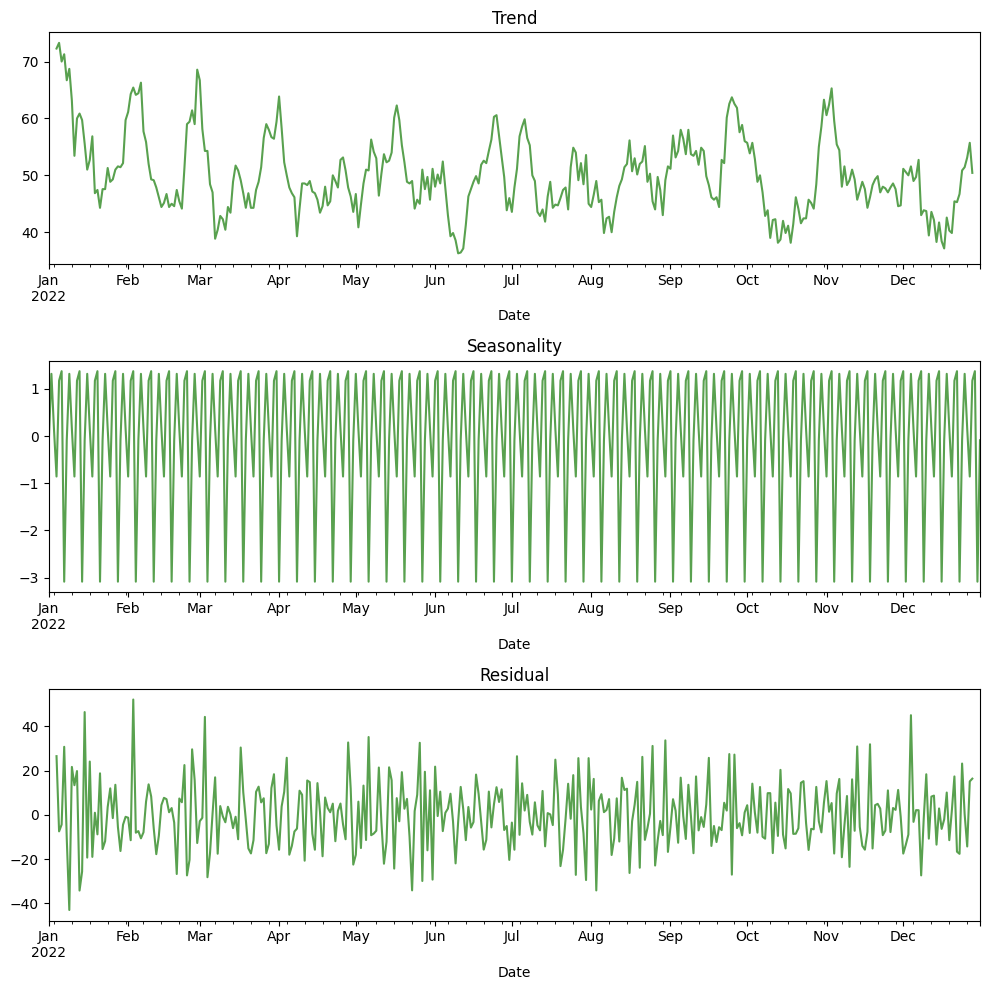

In [30]:
decomposed = seasonal_decompose(data_tsa.set_index('Date'))

plt.figure(figsize=(10, 10))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca(), color='#59A14F')
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca(), color='#59A14F')
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca(), color='#59A14F')
plt.title('Residual')

plt.tight_layout()

## 5.3. Stationarity Test

In [31]:
result = adfuller(data_tsa['Qty'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -19.018783
p-value: 0.000000
Critical Values:
	1%: -3.448
	5%: -2.870
	10%: -2.571


P-Value < 0,05 sehingga data stationery dapat digunakan dalam analisis time series dengan ARIMA.

<Axes: xlabel='Date', ylabel='Qty'>

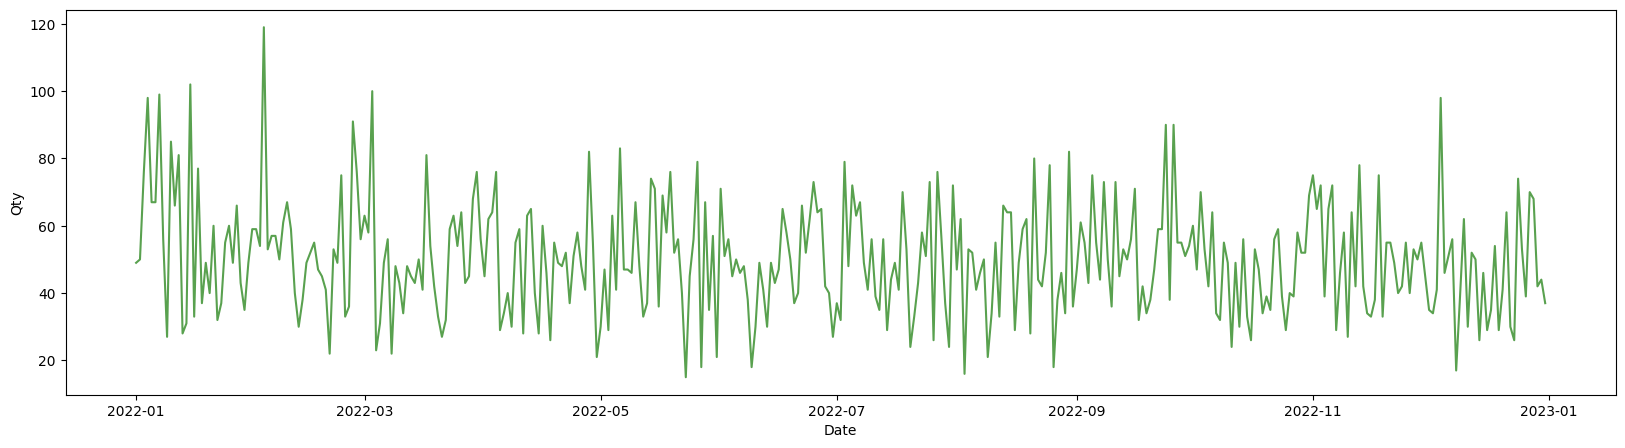

In [32]:
plt.figure(figsize=(20,5))
sns.lineplot(data=data_tsa, x=data_tsa['Date'], y=data_tsa['Qty'], color='#59A14F')

## 5.4. Finding The Value of The p, d, q Parameter

### 5.4.1. Finding the value of the d parameter

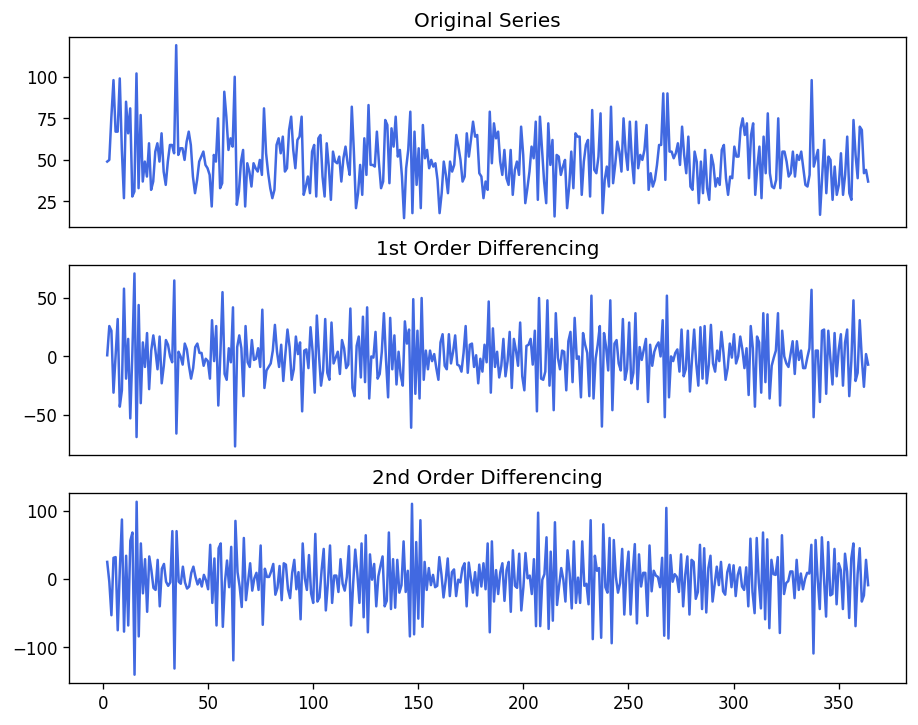

In [33]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

fig, (ax1, ax2, ax3) = plt.subplots(3)

ax1.plot(data_tsa.Qty, color='royalblue'); ax1.set_title('Original Series'); ax1.axes.xaxis.set_visible(False)

ax2.plot(data_tsa.Qty.diff(), color='royalblue'); ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)

ax3.plot(data_tsa.Qty.diff().diff(), color='royalblue'); ax3.set_title('2nd Order Differencing')

plt.show()

### 5.4.2. Melakukan Verifikasi d Parameter dengan Autocorelation Plot

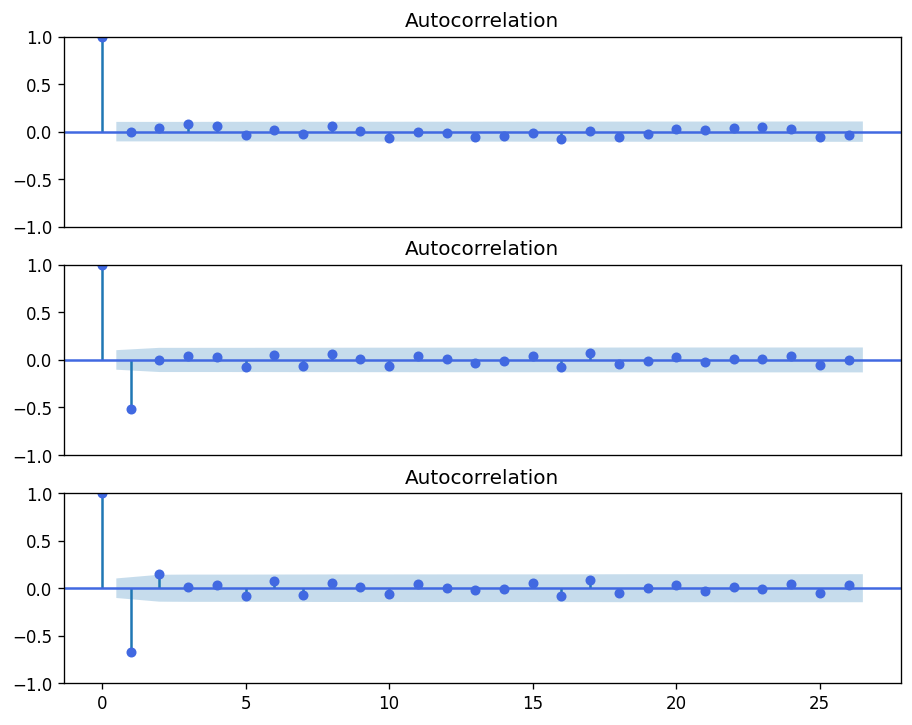

In [34]:
fig, (ax1, ax2, ax3) = plt.subplots(3)
plot_acf(data_tsa.Qty, color='royalblue', ax=ax1); ax1.axes.xaxis.set_visible(False)
plot_acf(data_tsa.Qty.diff().dropna(), color='royalblue', ax=ax2); ax2.axes.xaxis.set_visible(False)
plot_acf(data_tsa.Qty.diff().diff().dropna(), color='royalblue', ax=ax3);

### 5.4.3. Finding the value of the p parameter

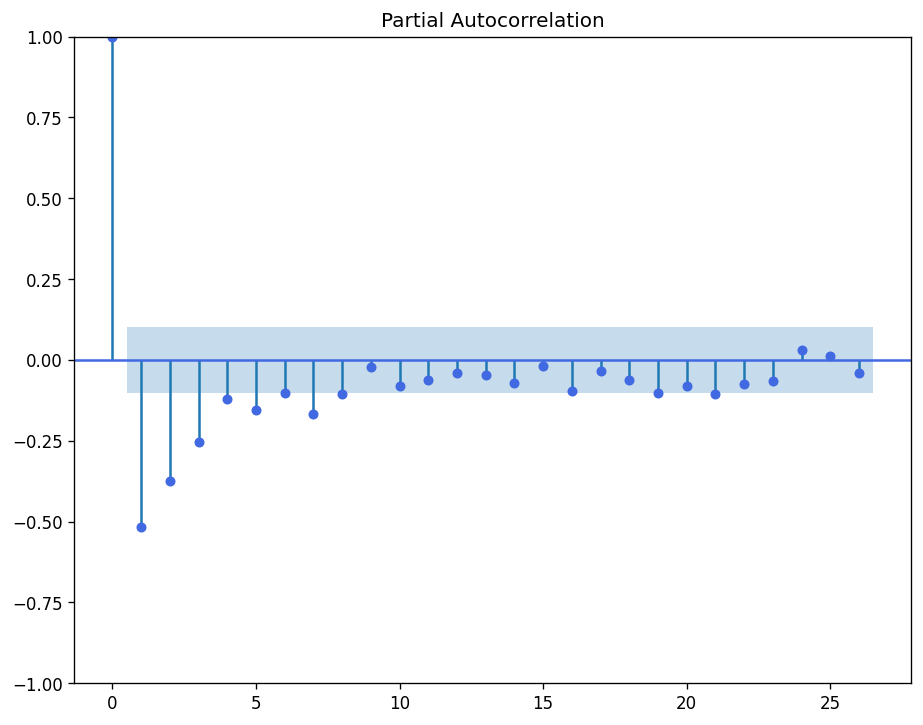

In [35]:
plot_pacf(data_tsa.Qty.diff().dropna(), color='royalblue');

### 5.4.4. Finding the value of the q parameter

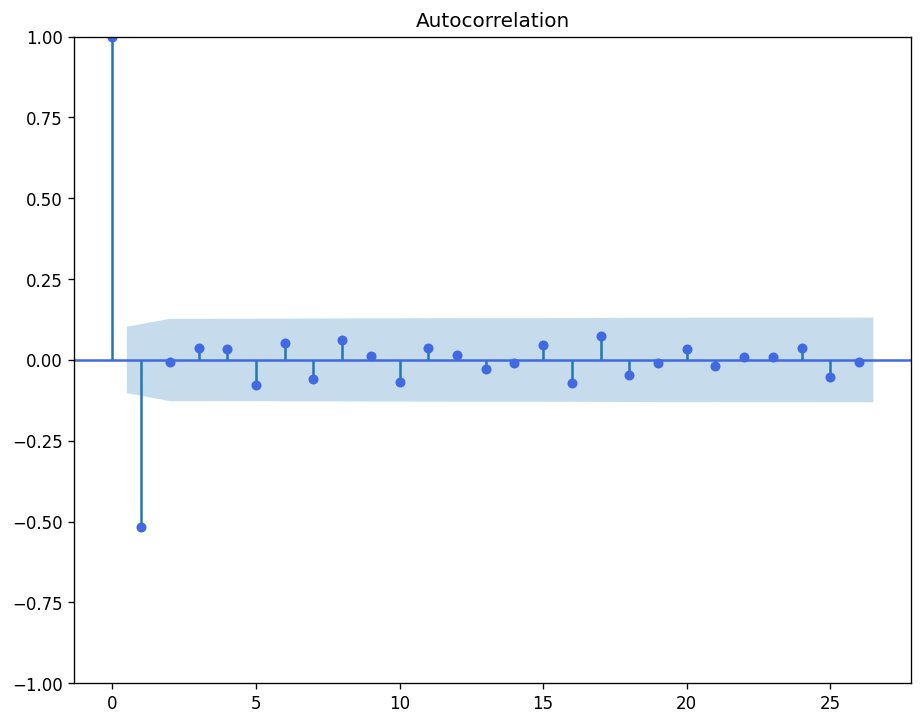

In [36]:
plot_acf(data_tsa.Qty.diff().dropna(), color='royalblue');

## 5.5. Building ARIMA Model

In [38]:
# train-test split
cut_off = round(data_tsa.shape[0]*0.8)
df_train = data_tsa[:cut_off]
df_test = data_tsa[cut_off:].reset_index(drop=True)
df_train.shape, df_test.shape

((292, 2), (73, 2))

In [39]:
# Pada Time series Analysis, data test harus melanjutkan data train

df_train

,Date,Qty
0,2022-01-01,49
1,2022-01-02,50
2,2022-01-03,76
3,2022-01-04,98
4,2022-01-05,67
...,...,...
287,2022-10-15,33
288,2022-10-16,26
289,2022-10-17,53
290,2022-10-18,47


In [40]:
df_test

,Date,Qty
0,2022-10-20,39
1,2022-10-21,35
2,2022-10-22,56
3,2022-10-23,59
4,2022-10-24,39
...,...,...
68,2022-12-27,70
69,2022-12-28,68
70,2022-12-29,42
71,2022-12-30,44


<Axes: xlabel='Date', ylabel='Qty'>

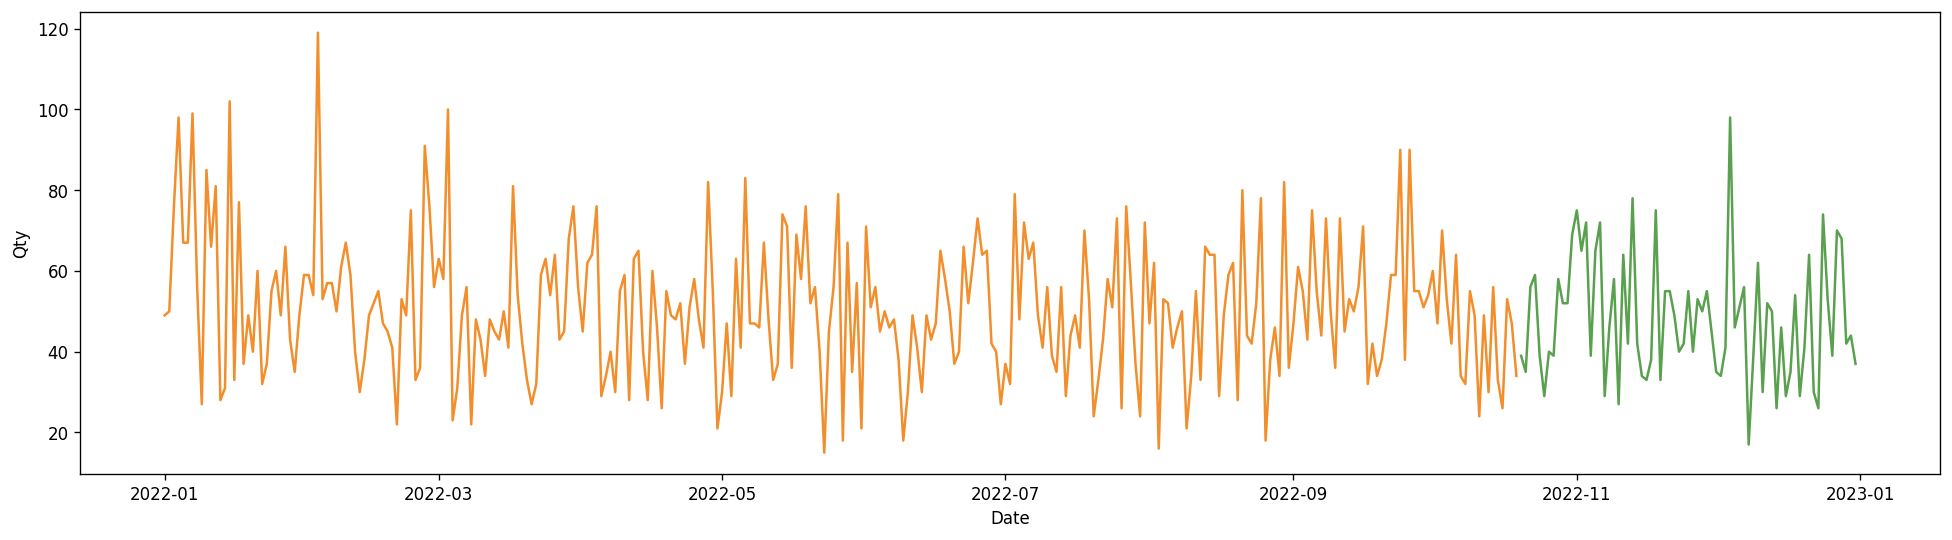

In [41]:
# train-test split line

plt.figure(figsize=(20,5))
sns.lineplot(data=df_train, x=df_train['Date'], y=df_train['Qty'], color='#F28E2B')
sns.lineplot(data=df_test, x=df_test['Date'], y=df_test['Qty'], color='#59A14F')

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

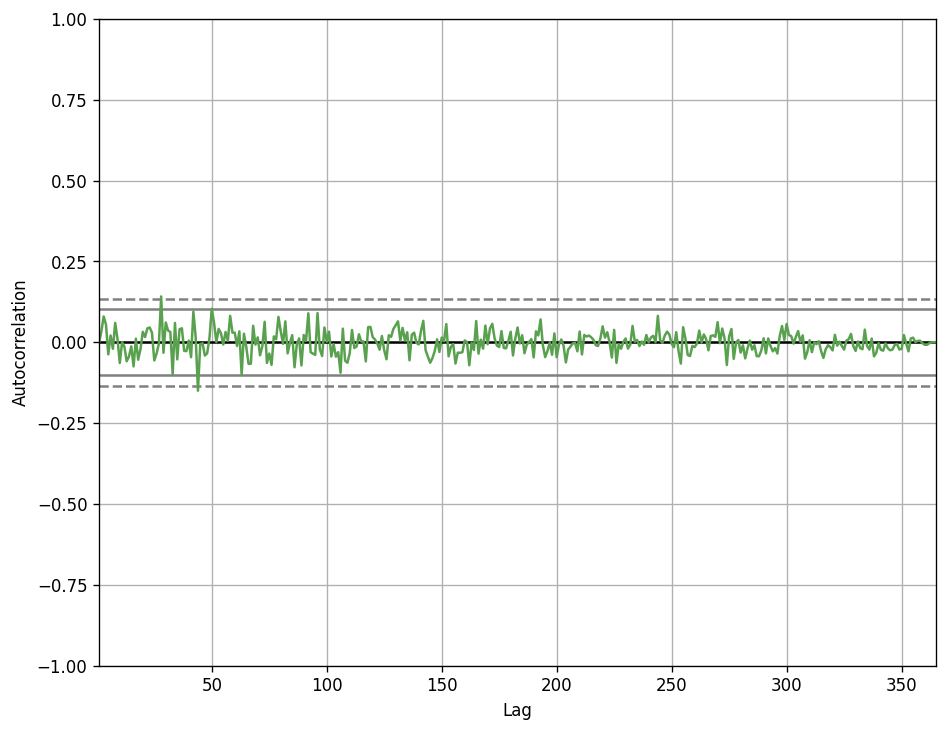

In [44]:
#autocorrelation plot

autocorrelation_plot(data_tsa['Qty'], color='#59A14F')

In [45]:
# defining evaluation model

def rmse(y_actual, y_pred):
    """
    function to calculate RMSE
    """

    print(f'RMSE value {mean_squared_error(y_actual, y_pred)**0.5}')

def eval(y_actual, y_pred):
    """
    function to eval machine learning modelling
    """

    rmse(y_actual, y_pred)
    print(f'MAE value {mean_absolute_error(y_actual, y_pred)}')

In [46]:
y = df_train['Qty']

df_train = df_train.set_index('Date')
df_test = df_test.set_index('Date')

RMSE value 16.80722771118357
MAE value 13.760085004301152


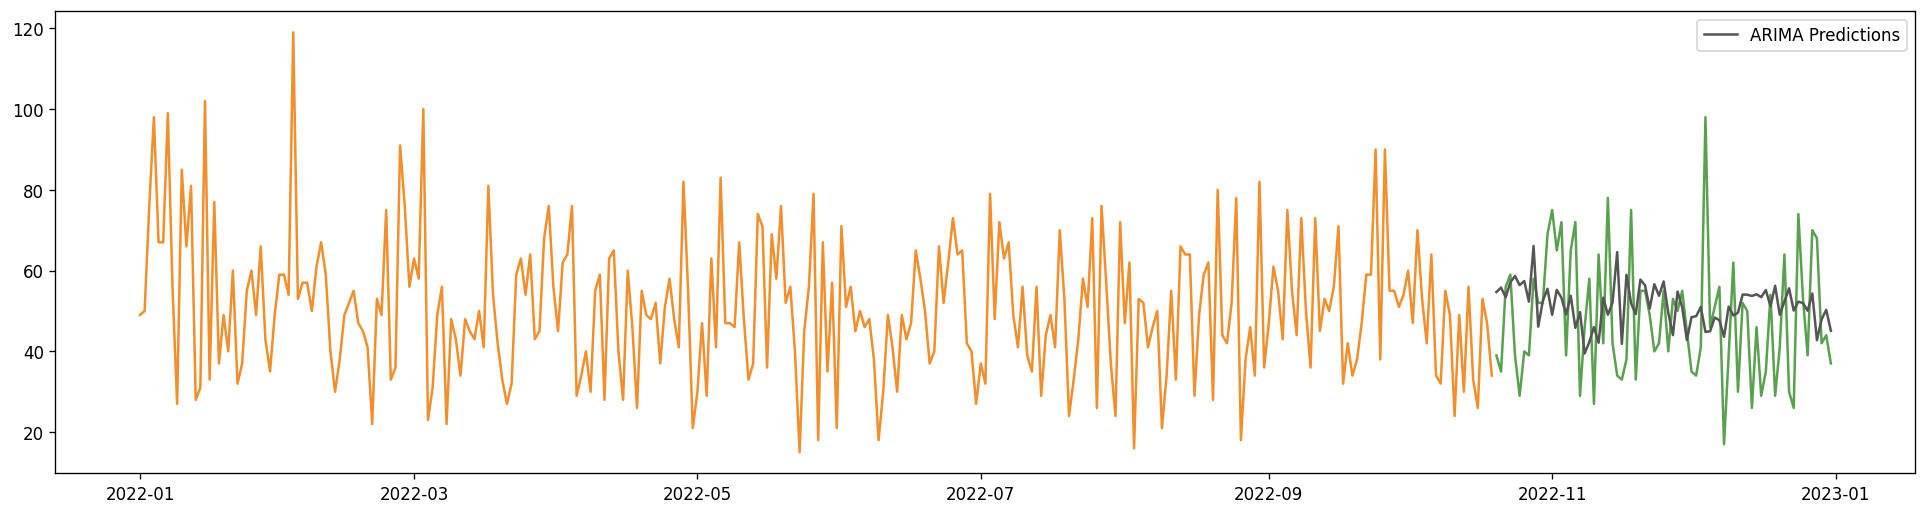

In [47]:
# hasil forcasting all product with results of evaluation model

ARIMAmodel = ARIMA(y, order=(50, 0, 2))
ARIMAmodel = ARIMAmodel.fit()

y_pred = ARIMAmodel.get_forecast(len(df_test))

y_pred_df = y_pred.conf_int()
y_pred_df['predictions'] = ARIMAmodel.predict(start=y_pred_df.index[0], end=y_pred_df.index[-1])
y_pred_df.index = df_test.index
y_pred_out = y_pred_df['predictions']
eval(df_test['Qty'], y_pred_out)

plt.figure(figsize=(20, 5))
plt.plot(df_train['Qty'], color='#F28E2B')
plt.plot(df_test['Qty'], color='#59A14F')
plt.plot(y_pred_out, color='#555555', label='ARIMA Predictions')
plt.legend()

In [50]:
# auto arima best model and prediction results

model = auto_arima(df_train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(df_train)
forecast = model.predict(n_periods=len(df_test))
forecast = pd.DataFrame(forecast, index=df_test.index, columns=['Predictions'])
print(forecast)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=2492.660, Time=3.50 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2486.299, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2488.299, Time=0.25 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2488.299, Time=0.60 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3153.727, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2490.294, Time=0.56 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 5.173 seconds
            Predictions
Date                   
2022-10-20    50.633562
2022-10-21    50.633562
2022-10-22    50.633562
2022-10-23    50.633562
2022-10-24    50.633562
...                 ...
2022-12-27    50.633562
2022-12-28    50.633562
2022-12-29    50.633562
2022-12-30    50.633562
2022-12-31    50.633562

[73 rows x 1 columns]


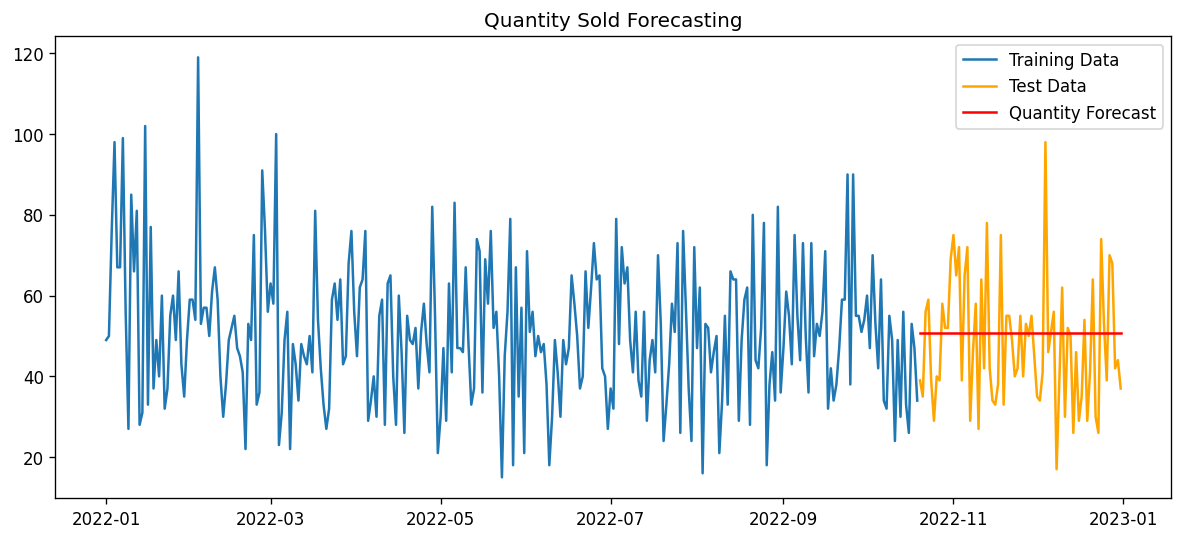

In [53]:
#Plot forecasting

plt.figure(figsize=(12,5))
plt.plot(df_train, label='Training Data')
plt.plot(df_test, color='orange', label='Test Data')
plt.plot(forecast,color='red', label= 'Quantity Forecast')
plt.title('Quantity Sold Forecasting')
plt.legend()
plt.show()

In [54]:
forecast.mean()

Predictions    50.633562
dtype: float64

In [49]:
#Forecasting the quantity of each product for the next month
product_name = df['Product Name'].unique()

dfprod = pd.DataFrame({'Date':pd.date_range(start='2023-01-01',end='2023-01-31')})
dfprod = dfprod.set_index('Date')
for i in product_name:
    df1 = df[['Date','Product Name','Qty']]
    df1 = df1[df1['Product Name']==i]
    df1 = df1.groupby('Date')[['Qty']].sum()
    df1 = df1.reset_index()
    df_prod = pd.DataFrame({'Date':pd.date_range(start='2022-01-01',end='2022-12-31')})
    df_prod = df_prod.merge(df1, how='left', on='Date')
    df_prod = df_prod.fillna(0)
    df_prod = df_prod.set_index('Date')

    model1 = ARIMA(df_prod, order=(1,0,1))
    model1_fit = model1.fit()
    forecast1 = model1_fit.forecast(steps=31)
    dfprod[i] = forecast1.values

dfprod.head()

,Crackers,Oat,Thai Tea,Choco Bar,Coffee Candy,Yoghurt,Ginger Candy,Cheese Stick,Cashew,Potato Chip
Date,,,,,,,,,,
2023-01-01,5.362668,2.682005,8.234507,6.918451,6.514016,5.291034,7.022506,5.043507,1.733288,3.082908
2023-01-02,4.810320,2.638355,7.536729,6.563289,6.480087,5.405974,7.235970,5.044549,1.712608,3.003115
2023-01-03,5.092543,2.644572,8.007669,6.601474,6.447643,5.370513,7.183734,5.044614,1.719941,2.993360
2023-01-04,4.948341,2.643686,7.689826,6.597368,6.416619,5.381453,7.196516,5.044618,1.717341,2.992167
2023-01-05,5.022021,2.643812,7.904342,6.597810,6.386954,5.378078,7.193388,5.044619,1.718263,2.992021


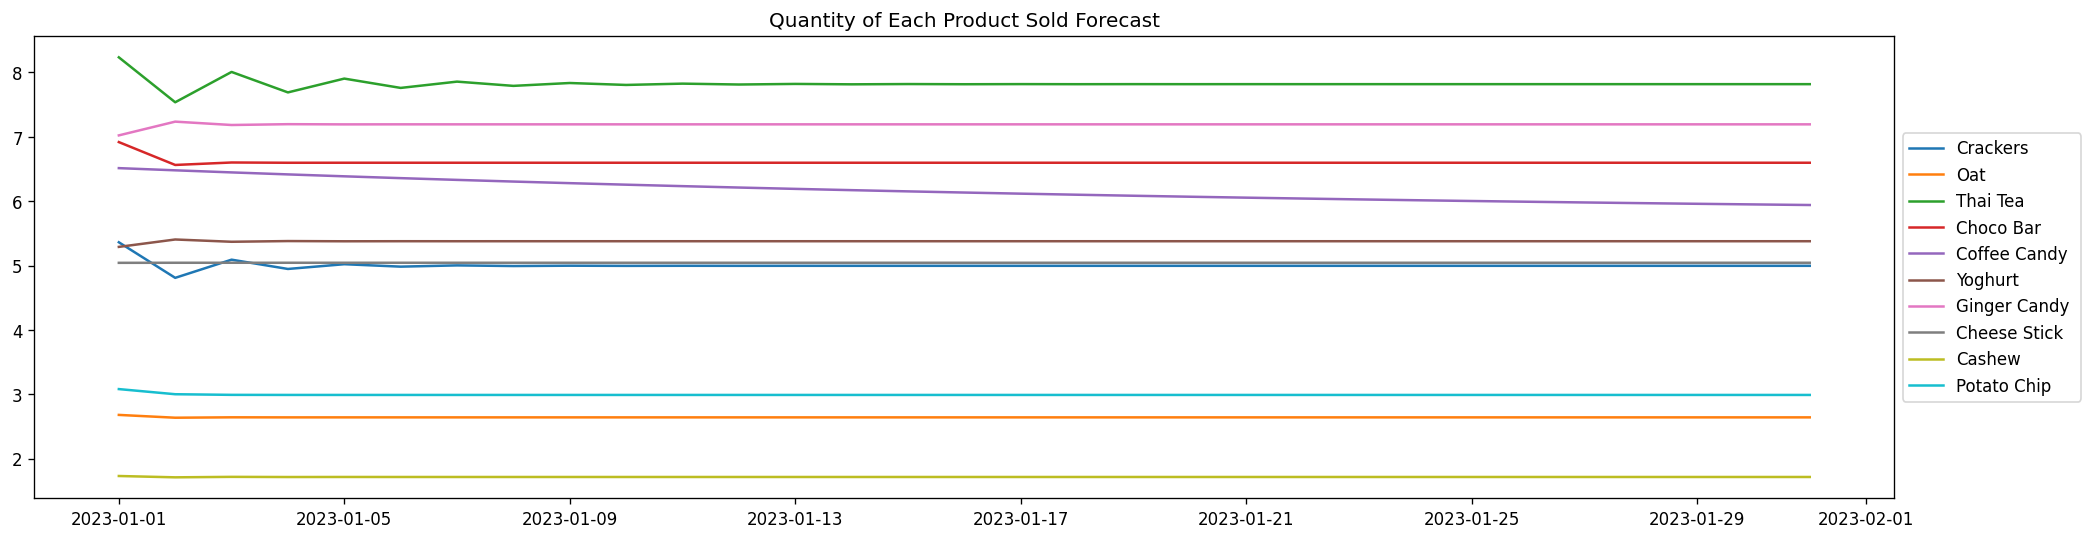

In [58]:
#Forecasting Plot
plt.figure(figsize=(20,5))
plt.plot(dfprod)
plt.legend(dfprod.columns,loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Quantity of Each Product Sold Forecast')
plt.show()

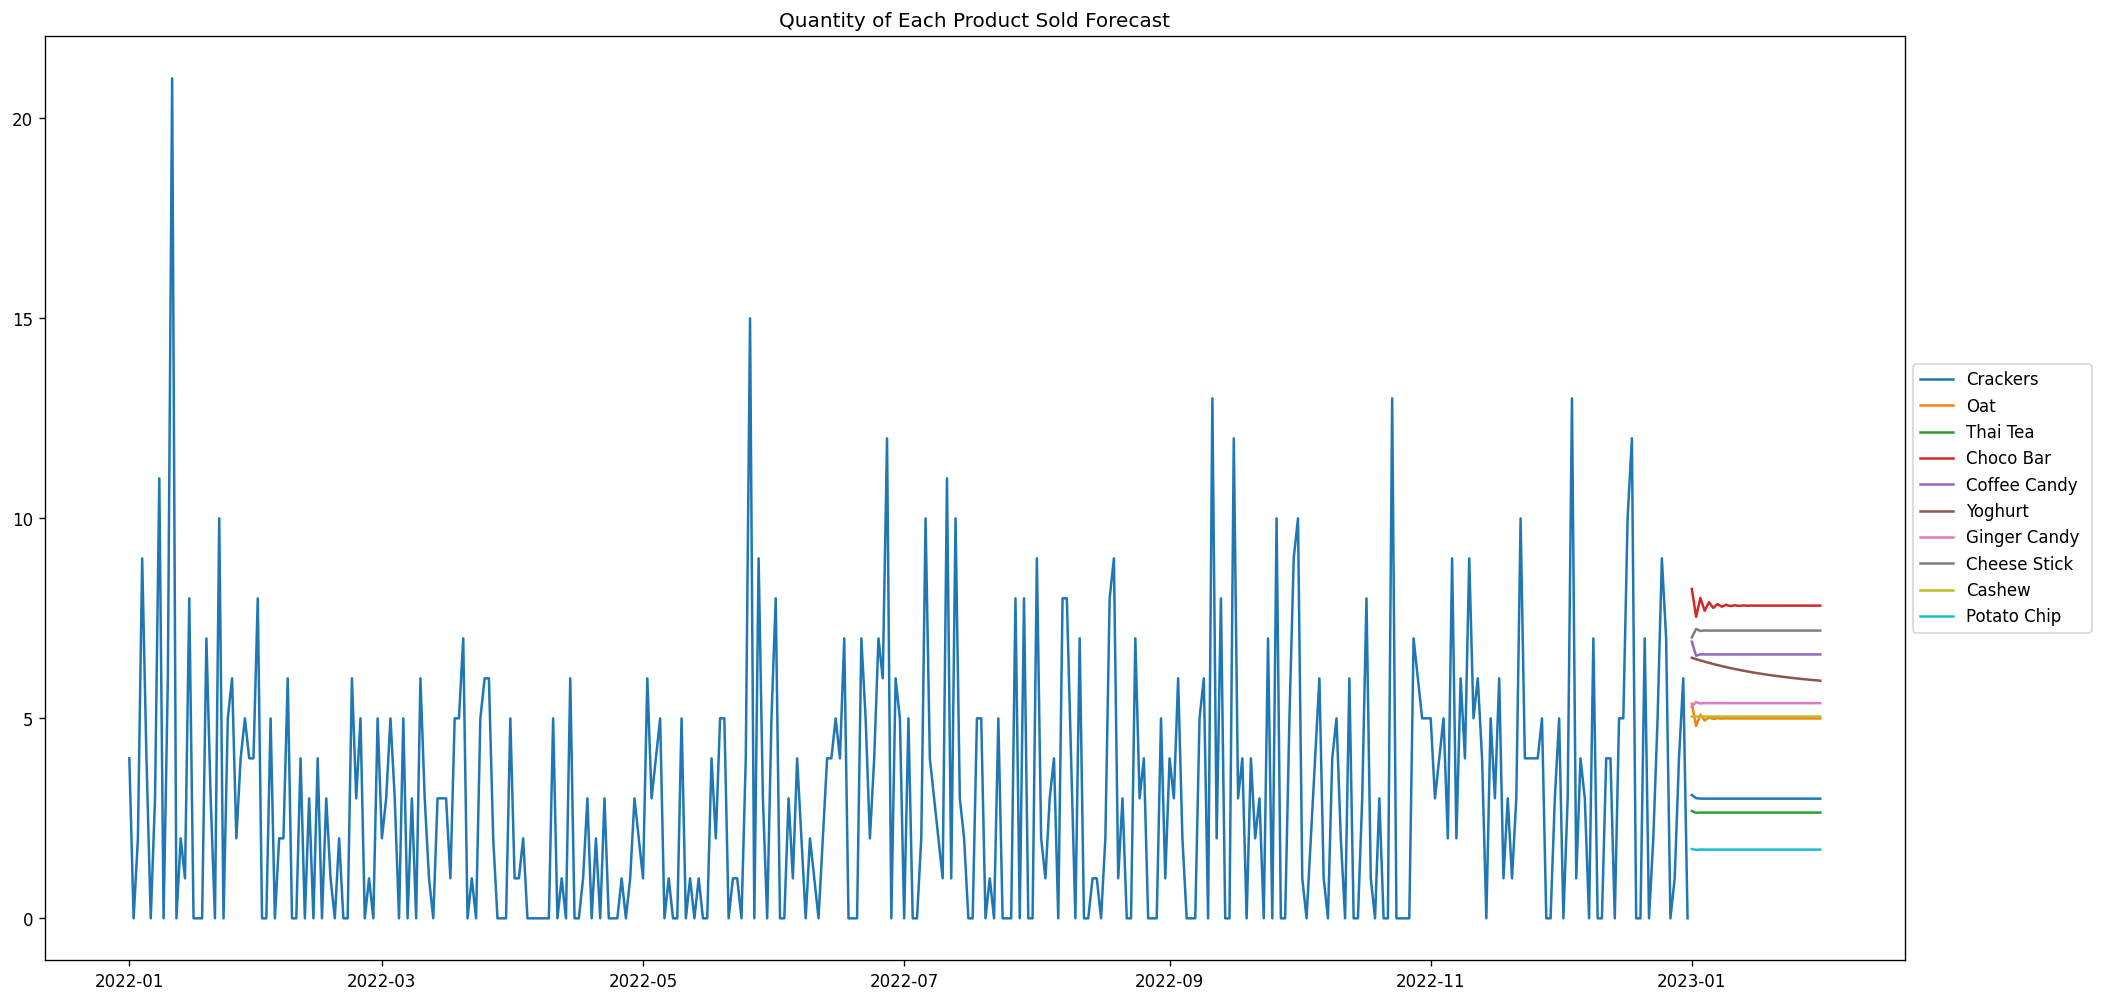

In [56]:
#Plot forecasting
plt.figure(figsize=(20,10))
plt.plot(df_prod)
plt.plot(dfprod, label= 'Quantity of Each Product Forecast')
plt.title('Quantity of Each Product Sold Forecast')
plt.legend(dfprod.columns, loc='center left', bbox_to_anchor=(1,0.5))
plt.show()

In [59]:
#Quantity of Each Product Sold forecast
round(dfprod.describe().T['mean'],0)

Crackers         5.0
Oat              3.0
Thai Tea         8.0
Choco Bar        7.0
Coffee Candy     6.0
Yoghurt          5.0
Ginger Candy     7.0
Cheese Stick     5.0
Cashew           2.0
Potato Chip      3.0
Name: mean, dtype: float64